In [1]:
# Parameters
experiment_config_path = None
experiment_output_dir = None

In [1]:
# Debugging
# experiment_config_path = '/lab/repos/celldom/config/experiment/experiment_example_G3.yaml'
# experiment_output_dir = '/lab/data/celldom/output/20180923-G3-full'

In [2]:
%matplotlib inline
import celldom
import os
import os.path as osp
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from skimage import io
from celldom.core.experiment import Experiment
from celldom.config import experiment_config
from celldom.execute import calculation

In [47]:
config = experiment_config.ExperimentConfig(experiment_config_path)
experiment = Experiment(config, data_dir=experiment_output_dir)

In [48]:
# For this part of the analysis, assume that we want to examine growth rates in all
# apartments regardless of their initial conditions
print('Apartment initial condition filter update: {} -> None'.format(config.get_analysis_config()['apartment_growth_rate']['initial_conditions_filter']))
config.get_analysis_config()['apartment_growth_rate']['initial_conditions_filter'] = None

Apartment initial condition filter update: ['single_cell', 'double_cell'] -> None


In [6]:
# Fetch apartment growth rate data (this may take a minute or two)
df = calculation.calculate_apartment_growth_rates(experiment, save=False)
df = calculation.remove_oob_apartments(experiment, df)
df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15582 entries, 0 to 15639
Data columns (total 20 columns):
acq_pump             15582 non-null object
acq_color            15582 non-null object
acq_condition        15582 non-null object
acq_cohort           15582 non-null object
st_num               15582 non-null object
apt_num              15582 non-null object
acq_ids              15582 non-null object
cell_counts          15582 non-null object
confluence           15582 non-null object
elapsed_hours_min    15582 non-null float64
first_count          15582 non-null float64
first_date           15582 non-null datetime64[ns]
growth_rate          15565 non-null float64
last_count           15582 non-null float64
last_date            15582 non-null datetime64[ns]
max_cell_count       15582 non-null float64
min_cell_count       15582 non-null float64
n                    15582 non-null int64
occupancies          15582 non-null object
array                15582 non-null object
dtypes: da

In [10]:
df['growth_rate'].describe()

count    15565.000000
mean         0.168967
std          0.325787
min         -1.260297
25%         -0.007495
50%          0.114326
75%          0.304660
max          1.896569
Name: growth_rate, dtype: float64

## Array Heatmap Visualization

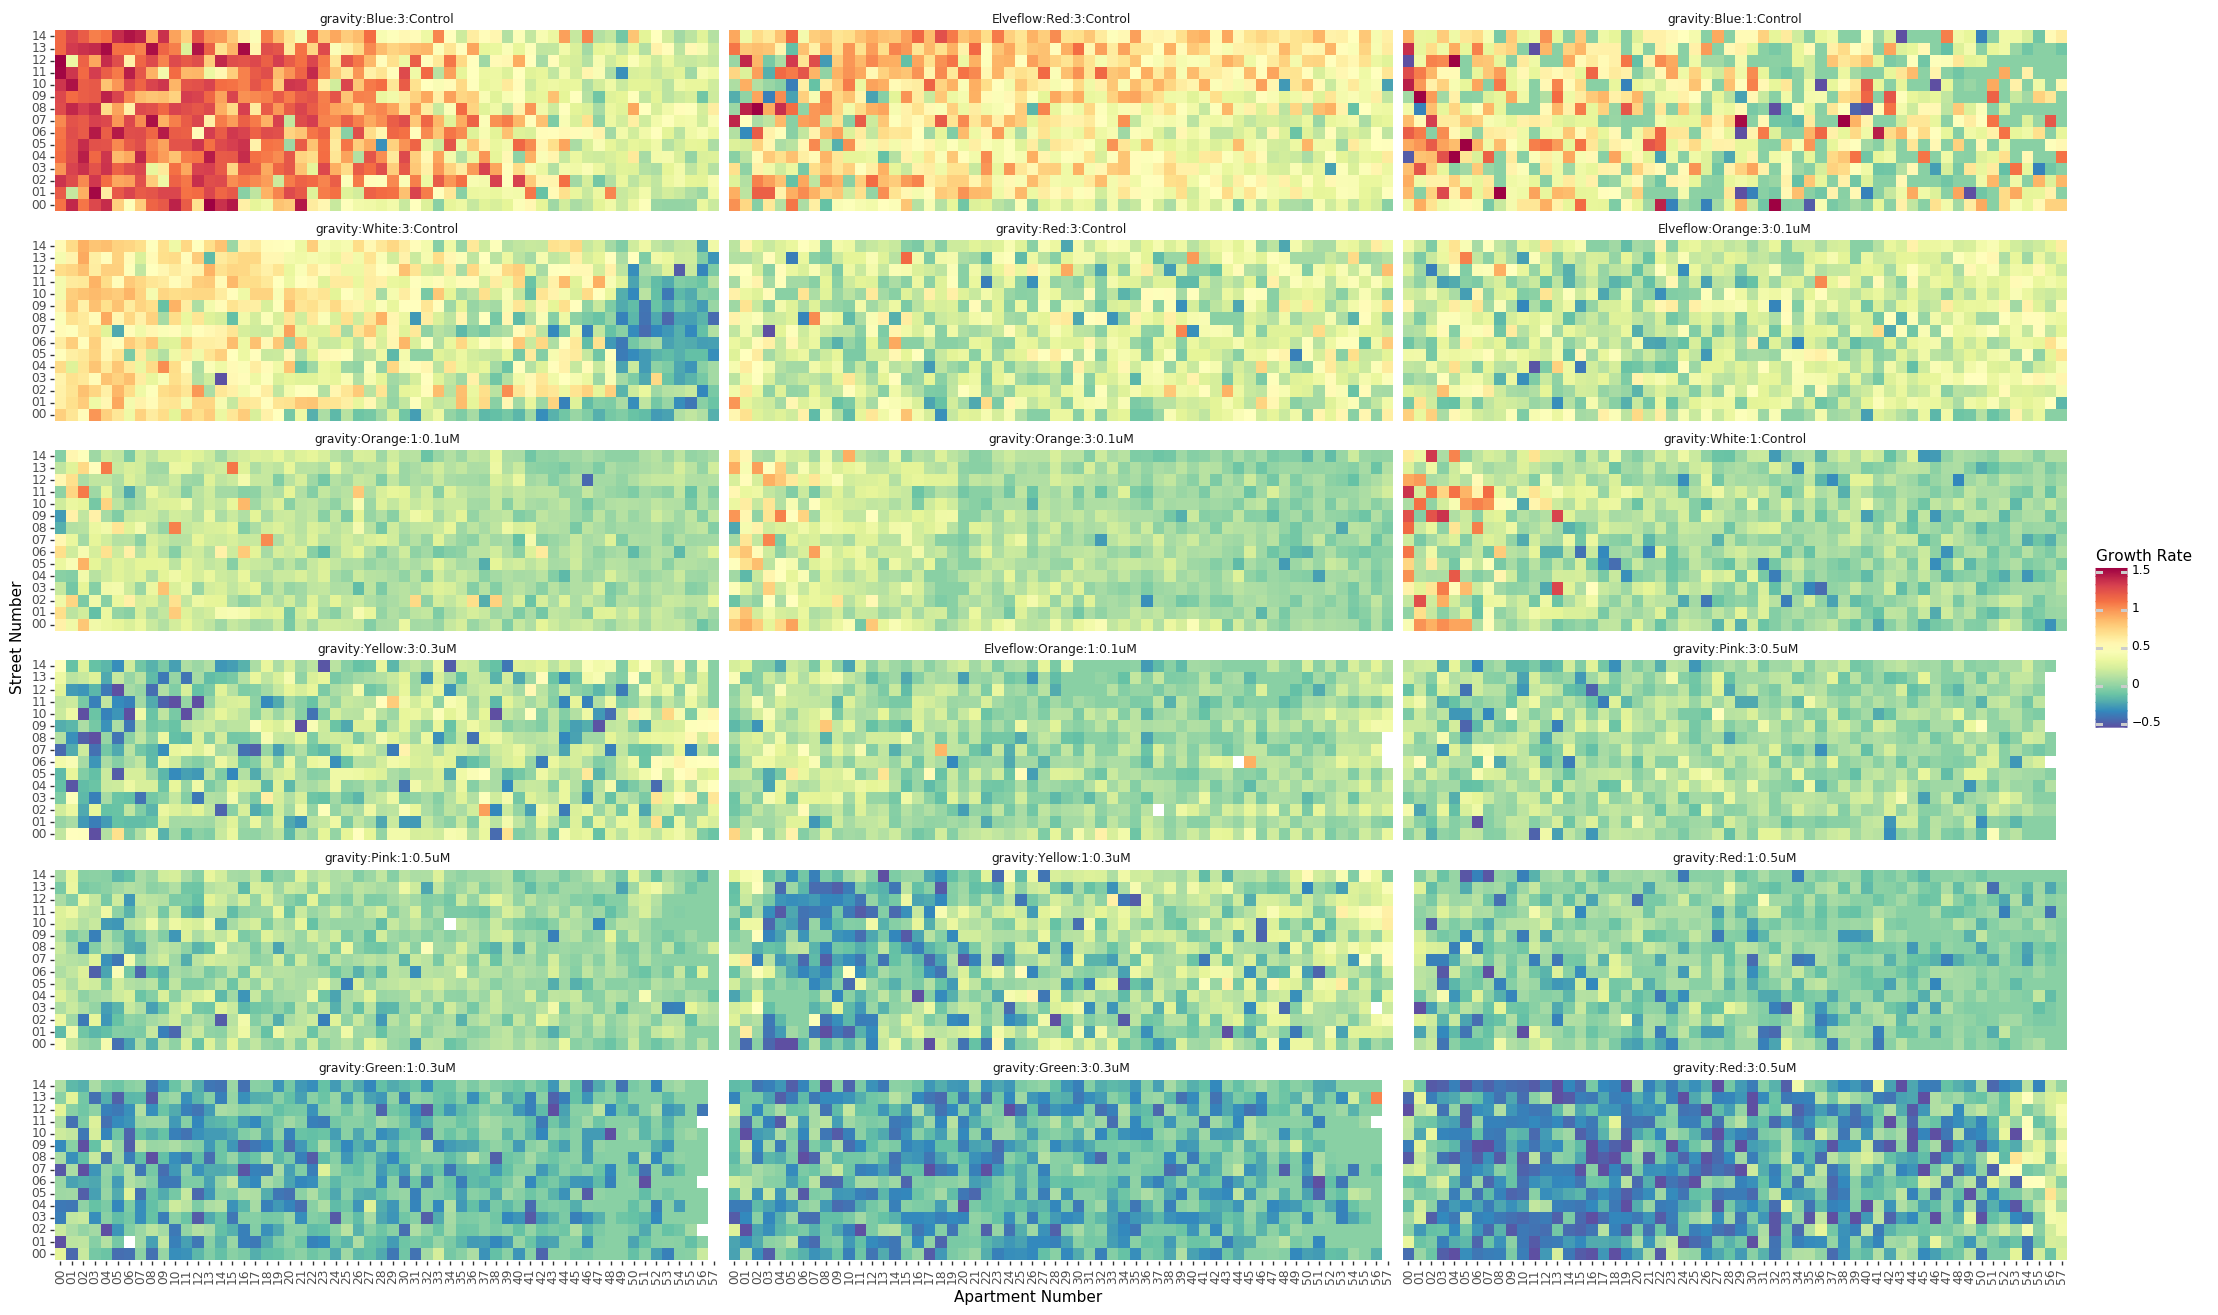

<ggplot: (8737865166600)>

In [46]:
(
    pn.ggplot(
        (
            df
            .assign(**{'Growth Rate': df['growth_rate'].fillna(0)})
            .assign(array=pd.Categorical(
                df['array'], ordered=True,
                categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
            ))
        ), 
        pn.aes(x='apt_num', y='st_num', fill='Growth Rate')
    ) +
    pn.geom_tile() +
    pn.scale_fill_cmap(name='Spectral_r', limits=(-.5, 1.5)) +#, guide=pn.guide_legend(title='Growth Rate')) +
    pn.facet_wrap('~array', ncol=3) +
    pn.xlab('Apartment Number') +
    pn.ylab('Street Number') +
    pn.theme(
        figure_size=(26,16),
        axis_text_x=pn.element_text(rotation=90, hjust=.5),
        panel_background=pn.element_rect(fill="white"),
        strip_background=pn.element_rect(fill="white")
    )
)